# 04 — EDA: Text Feature Scoring

**Goal:** Run all three stages of text feature engineering and validate signal quality.

**Sections:**
1. Setup
2. Stage 4a — Keyword scoring
3. Stage 4b — LLM rubric scoring
4. Stage 4c — Embeddings + PCA
5. Sanity checks
6. Save

## 1. Setup

In [1]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_CLEAN = PROJECT_ROOT / "data-clean"
OUTPUTS    = PROJECT_ROOT / "outputs"
PROMPTS    = OUTPUTS / "prompts"
FIGURES    = OUTPUTS / "figures"

import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import load_config
from src.clean import read_parquet, write_parquet
from src.ingest import load_transcripts_json
from src.features_text import (
    score_transcripts_keywords,
    score_transcripts_llm,
    make_embeddings,
    build_text_features,
)

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
warnings.filterwarnings("ignore")

cfg = load_config(PROJECT_ROOT / "configs" / "config.yaml")
print(f"LLM model: {cfg.text.llm_model}")

LLM model: claude-sonnet-4-6


In [2]:
fomc       = read_parquet(DATA_CLEAN / "fomc_metadata.parquet")
targets    = read_parquet(DATA_CLEAN / "targets.parquet")
transcripts = load_transcripts_json(DATA_CLEAN / "transcripts.json")

meeting_ids = fomc["meeting_id"].tolist()
print(f"Meetings: {len(meeting_ids)}, transcripts loaded: {len(transcripts)}")

INFO: Read 41 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/fomc_metadata.parquet
INFO: Read 328 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/targets.parquet


Meetings: 41, transcripts loaded: 41


## 2. Stage 4a — Keyword Scoring

In [3]:
kw_scores = score_transcripts_keywords(transcripts, meeting_ids)
kw_scores.head(8)

INFO: Keyword scores: 82 rows


,meeting_id,text_source,hawkish_count,dovish_count,net_hawkish,net_hawkish_norm,balance_sheet_kw,uncertainty_kw
0,20210127,statement,11,9,2,0.002099,3,6
1,20210127,press_conf,55,48,7,0.000758,20,14
2,20210317,statement,12,8,4,0.004246,3,6
3,20210317,press_conf,76,37,39,0.003839,22,29
4,20210428,statement,11,9,2,0.002132,3,6
5,20210428,press_conf,83,22,61,0.006209,37,8
6,20210616,statement,11,12,-1,-0.001006,3,6
7,20210616,press_conf,110,24,86,0.008256,22,18


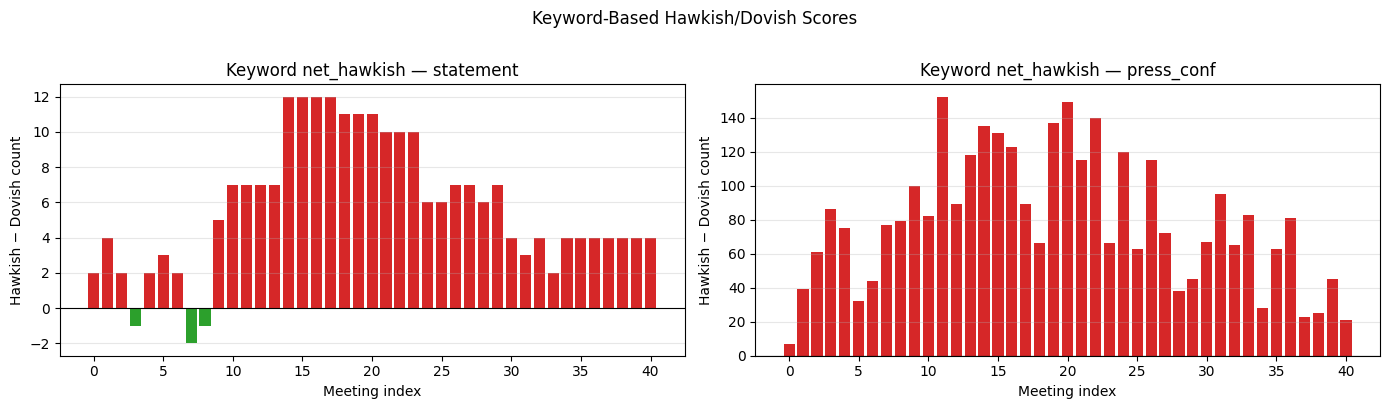

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, text_source in zip(axes, ["statement", "press_conf"]):
    sub = kw_scores[kw_scores["text_source"] == text_source].copy()
    sub = sub.merge(fomc[["meeting_id", "announcement_et"]], on="meeting_id")
    sub = sub.sort_values("announcement_et")

    colors = ["#d62728" if x > 0 else "#2ca02c" for x in sub["net_hawkish"]]
    ax.bar(range(len(sub)), sub["net_hawkish"], color=colors)
    ax.axhline(0, color="k", lw=0.8)
    ax.set_title(f"Keyword net_hawkish — {text_source}")
    ax.set_xlabel("Meeting index")
    ax.set_ylabel("Hawkish − Dovish count")
    ax.grid(True, alpha=0.3, axis="y")

plt.suptitle("Keyword-Based Hawkish/Dovish Scores", y=1.01)
plt.tight_layout()
plt.show()

## 3. Stage 4b — LLM Rubric Scoring

In [5]:
# Check if already scored (avoid re-running API calls)
llm_cache = DATA_CLEAN / "llm_scores_cache.parquet"

if llm_cache.exists():
    print(f"Loading cached LLM scores from {llm_cache}")
    llm_scores = read_parquet(llm_cache)
else:
    print(f"Running LLM scoring (82 API calls via {cfg.text.llm_model}) ...")
    llm_scores = score_transcripts_llm(
        transcripts=transcripts,
        meeting_ids=meeting_ids,
        prompt_path=PROMPTS / f"rubric_{cfg.text.prompt_version}.txt",
        llm_model=cfg.text.llm_model,
        log_dir=OUTPUTS,
    )
    write_parquet(llm_scores, llm_cache)
    print(f"Cached to {llm_cache}")

llm_scores.head(6)

INFO: Read 82 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/llm_scores_cache.parquet


Loading cached LLM scores from /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/llm_scores_cache.parquet


,meeting_id,text_source,llm_model_id,hawkish_dovish,inflation_focus,labor_focus,recession_risk,uncertainty_score,forward_guidance_strength,balance_sheet_mention
0,20210127,statement,claude-sonnet-4-6,-2.0,1.0,1.0,1.0,1.0,2.0,1.0
1,20210127,press_conf,claude-sonnet-4-6,-2.0,-1.0,2.0,1.0,2.0,2.0,1.0
2,20210317,statement,claude-sonnet-4-6,-2.0,-1.0,1.0,1.0,2.0,2.0,1.0
3,20210317,press_conf,claude-sonnet-4-6,-2.0,0.0,2.0,1.0,2.0,2.0,1.0
4,20210428,statement,claude-sonnet-4-6,-2.0,0.0,1.0,1.0,1.0,2.0,1.0
5,20210428,press_conf,claude-sonnet-4-6,-2.0,1.0,2.0,0.0,1.0,2.0,1.0


In [6]:
rubric_cols = ["hawkish_dovish", "inflation_focus", "labor_focus",
               "recession_risk", "uncertainty_score", "forward_guidance_strength",
               "balance_sheet_mention"]

print("LLM score distributions:")
print(llm_scores.groupby("text_source")[rubric_cols].describe().round(2))

LLM score distributions:
            hawkish_dovish                                       \
                     count  mean   std  min  25%  50%  75%  max   
text_source                                                       
press_conf            41.0  0.32  1.17 -2.0 -1.0  1.0  1.0  2.0   
statement             41.0  0.34  1.30 -2.0 -1.0  1.0  1.0  2.0   

            inflation_focus        ... forward_guidance_strength       \
                      count  mean  ...                       75%  max   
text_source                        ...                                  
press_conf             41.0  1.49  ...                       2.0  2.0   
statement              41.0  1.41  ...                       2.0  2.0   

            balance_sheet_mention                                       
                            count  mean   std  min  25%  50%  75%  max  
text_source                                                             
press_conf                   41.0  0.98  0.16  0.0  1.

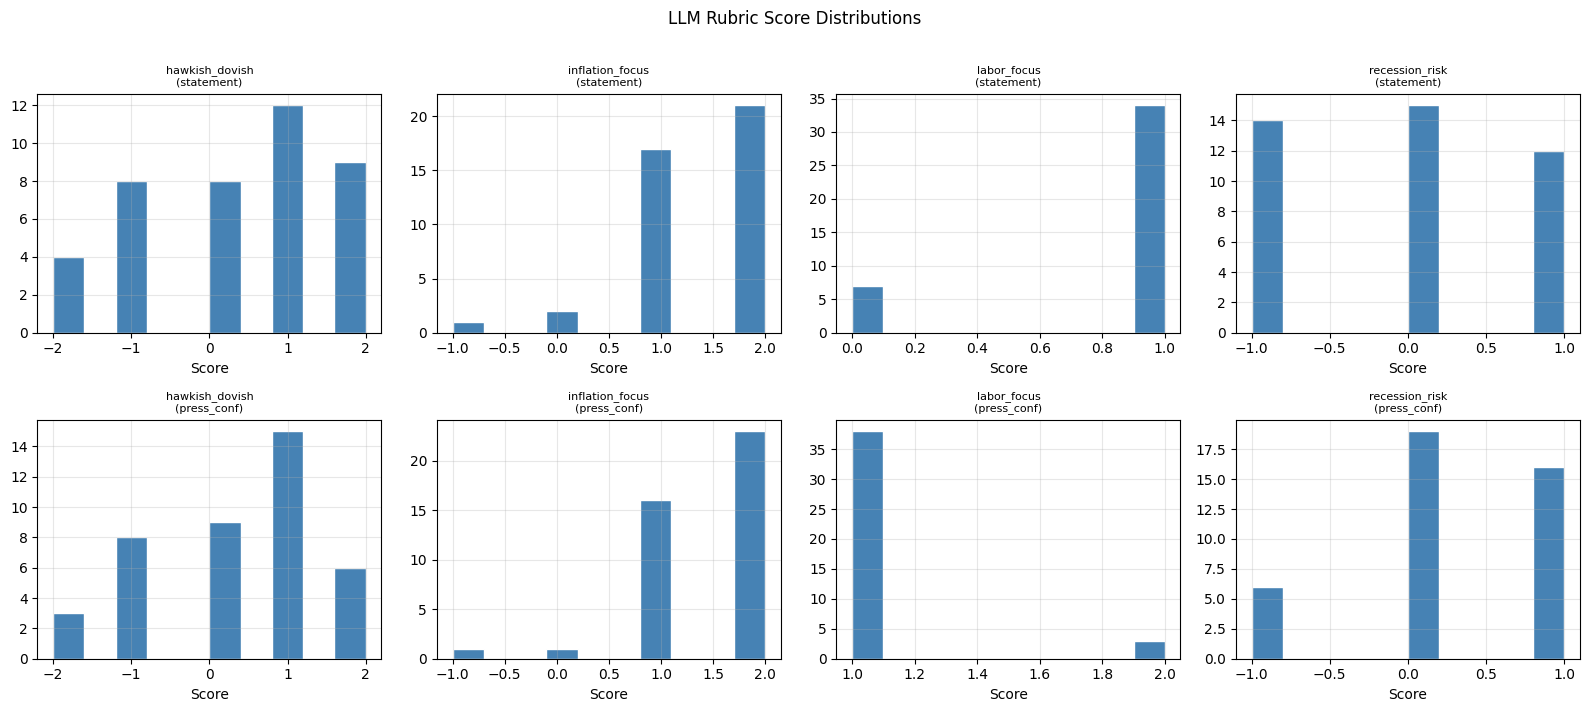

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
rubric_display = rubric_cols[:7]  # 7 dimensions

for text_source, row_axes in zip(["statement", "press_conf"], [axes[0], axes[1]]):
    sub = llm_scores[llm_scores["text_source"] == text_source]
    for ax, col in zip(row_axes, rubric_display):
        ax.hist(sub[col].dropna(), bins=10, edgecolor="white", color="steelblue")
        ax.set_title(f"{col}\n({text_source})", fontsize=8)
        ax.set_xlabel("Score")
        ax.grid(True, alpha=0.3)
    # hide last subplot if 7 dims and 8 slots
    if len(row_axes) > len(rubric_display):
        row_axes[-1].set_visible(False)

plt.suptitle("LLM Rubric Score Distributions", y=1.01)
plt.tight_layout()
plt.show()

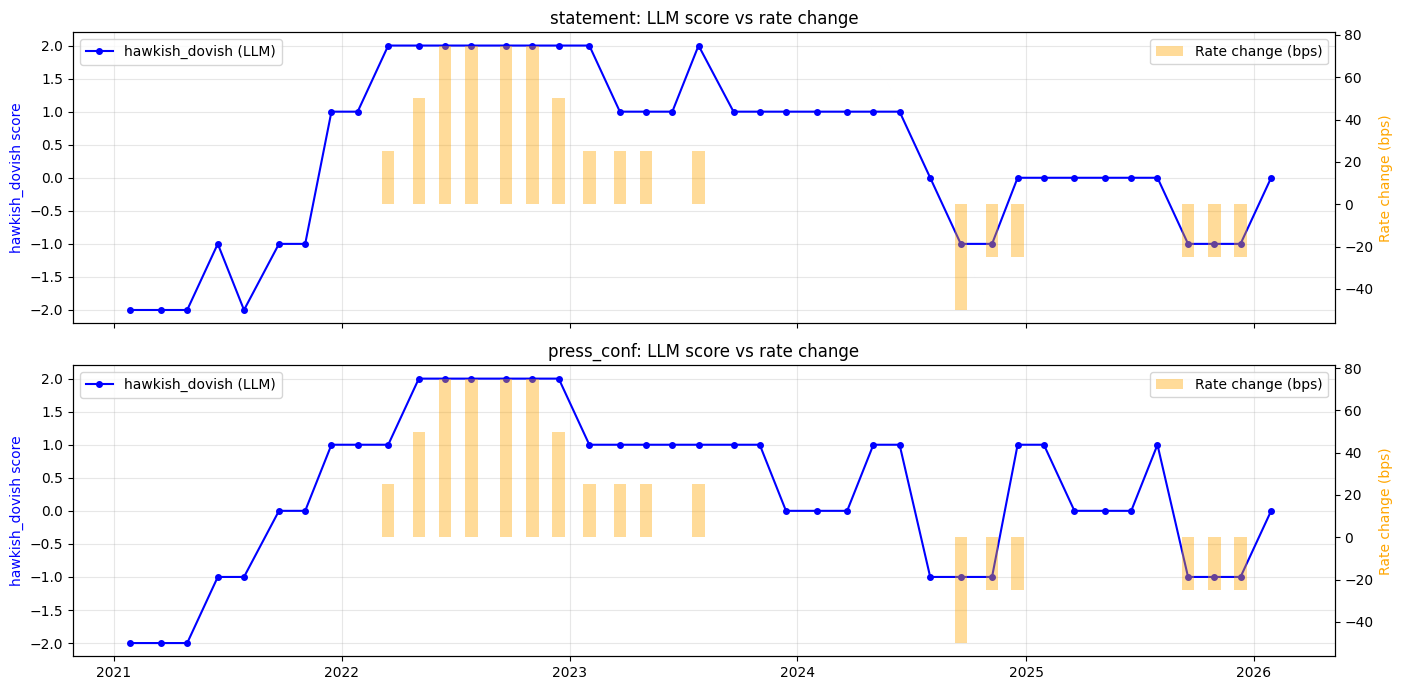

In [8]:
# Timeline: hawkish_dovish score vs actual rate changes
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

for ax, text_source in zip(axes, ["statement", "press_conf"]):
    sub = llm_scores[llm_scores["text_source"] == text_source].copy()
    sub = sub.merge(fomc[["meeting_id", "announcement_et", "rate_change"]], on="meeting_id")
    sub = sub.sort_values("announcement_et")

    ax2 = ax.twinx()
    ax.plot(sub["announcement_et"], sub["hawkish_dovish"], "b-o", ms=4, label="hawkish_dovish (LLM)")
    ax2.bar(sub["announcement_et"], sub["rate_change"] * 100, width=20, alpha=0.4, color="orange", label="Rate change (bps)")
    ax.set_ylabel("hawkish_dovish score", color="b")
    ax2.set_ylabel("Rate change (bps)", color="orange")
    ax.set_title(f"{text_source}: LLM score vs rate change")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Stage 4c — Embeddings + PCA

In [9]:
# Check if already computed
emb_cache = DATA_CLEAN / "embeddings_cache.parquet"

if emb_cache.exists():
    print(f"Loading cached embeddings from {emb_cache}")
    emb_scores = read_parquet(emb_cache)
else:
    print("Computing embeddings (requires sentence-transformers) ...")
    emb_scores = make_embeddings(
        transcripts=transcripts,
        meeting_ids=meeting_ids,
        n_components_min=cfg.text.embedding_dim_min,
        n_components_max=cfg.text.embedding_dim_max,
        figures_dir=FIGURES,
    )
    write_parquet(emb_scores, emb_cache)
    print(f"Cached to {emb_cache}")

emb_cols = [c for c in emb_scores.columns if c.startswith("emb_pc_")]
print(f"Embedding components: {len(emb_cols)} per text_source")
emb_scores.head(4)

INFO: Read 82 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/embeddings_cache.parquet


Loading cached embeddings from /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/embeddings_cache.parquet
Embedding components: 13 per text_source


,meeting_id,text_source,emb_pc_1,emb_pc_2,emb_pc_3,emb_pc_4,emb_pc_5,emb_pc_6,emb_pc_7,emb_pc_8,emb_pc_9,emb_pc_10,emb_pc_11,emb_pc_12,emb_pc_13
0,20210127,statement,21.126581,-4.631425,0.453574,2.819921,0.813826,-1.892743,-0.276386,-0.272505,NaN,NaN,NaN,NaN,NaN
1,20210317,statement,19.490446,-4.669845,0.632570,4.150646,0.837807,-1.929766,1.142982,-1.656917,NaN,NaN,NaN,NaN,NaN
2,20210428,statement,21.337875,-5.038410,0.727287,3.961240,-0.521819,-2.350241,0.897171,0.788149,NaN,NaN,NaN,NaN,NaN
3,20210616,statement,18.487770,-6.045004,1.954440,5.116384,-2.535055,-1.995268,0.686575,2.436828,NaN,NaN,NaN,NaN,NaN


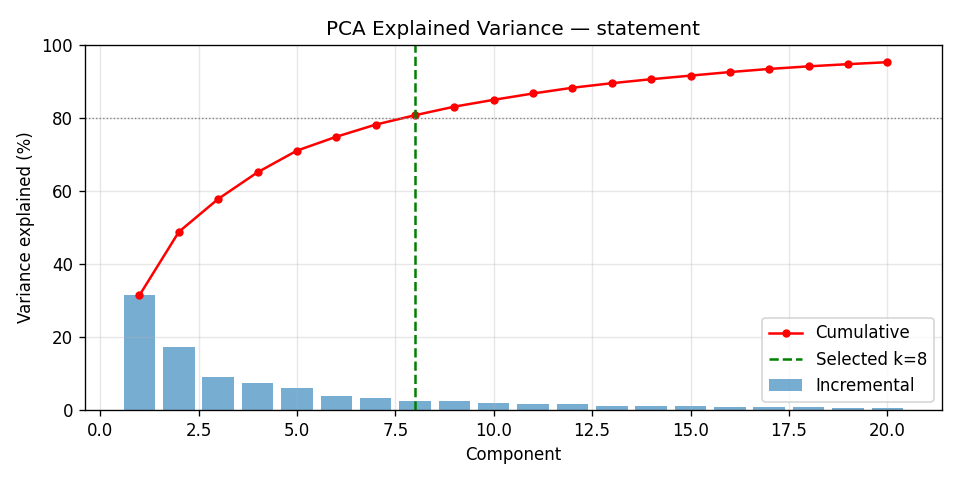

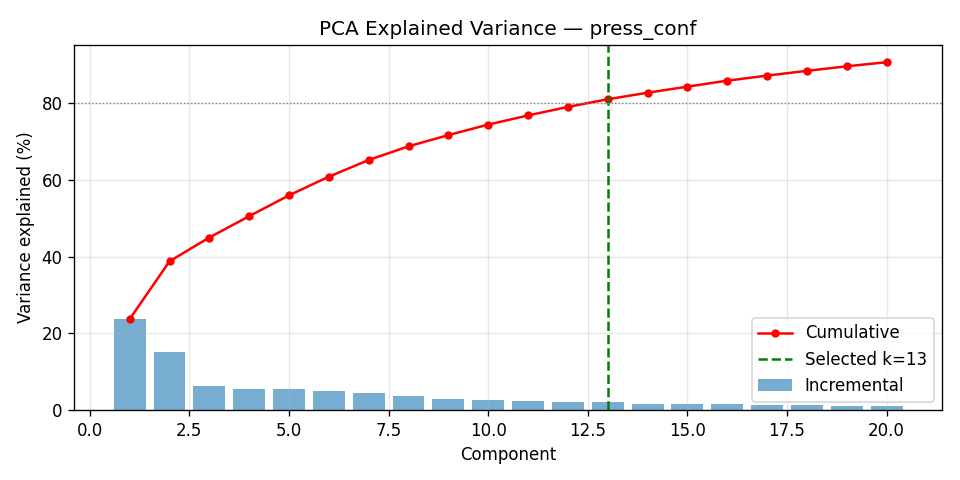

In [10]:
# Show PCA variance plots if saved
for text_source in ["statement", "press_conf"]:
    fig_path = FIGURES / f"pca_variance_{text_source}.png"
    if fig_path.exists():
        from IPython.display import Image, display
        display(Image(str(fig_path)))
    else:
        print(f"PCA plot not found at {fig_path} (run embedding stage above)")

## 5. Sanity Checks

In [11]:
# Key sanity check: hawkish_dovish (LLM) should correlate with net_hawkish (keyword)
stmt_kw  = kw_scores[kw_scores["text_source"] == "statement"][["meeting_id", "net_hawkish", "net_hawkish_norm"]]
stmt_llm = llm_scores[llm_scores["text_source"] == "statement"][["meeting_id", "hawkish_dovish"]]
sanity = stmt_kw.merge(stmt_llm, on="meeting_id")

corr_kw_llm = sanity[["net_hawkish", "hawkish_dovish"]].corr().iloc[0, 1]
print(f"Keyword net_hawkish vs LLM hawkish_dovish correlation: r = {corr_kw_llm:.3f}")

if corr_kw_llm > 0.3:
    print("✓ Positive correlation — LLM and keyword scores broadly agree")
elif corr_kw_llm > 0:
    print("⚠ Weak positive correlation — check a few low-agreement meetings")
else:
    print("✗ Negative or zero correlation — review LLM prompt or word lists")

Keyword net_hawkish vs LLM hawkish_dovish correlation: r = 0.611
✓ Positive correlation — LLM and keyword scores broadly agree


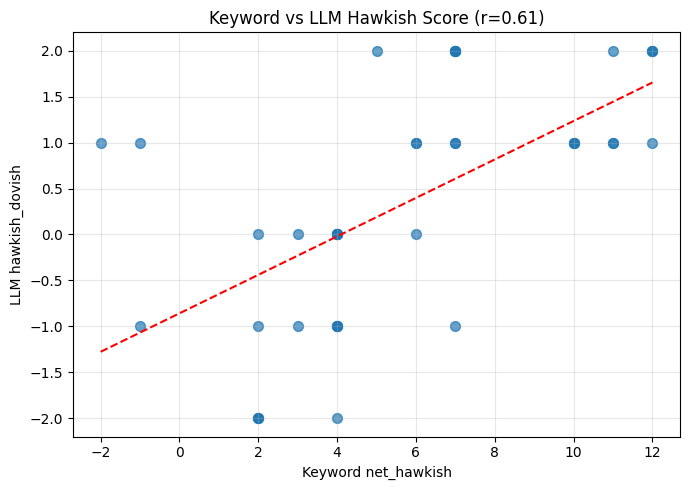

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(sanity["net_hawkish"], sanity["hawkish_dovish"], alpha=0.7, s=50)
z = np.polyfit(sanity["net_hawkish"].dropna(), sanity["hawkish_dovish"].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(sanity["net_hawkish"].min(), sanity["net_hawkish"].max(), 50)
ax.plot(x_line, p(x_line), "r--", lw=1.5)
ax.set_title(f"Keyword vs LLM Hawkish Score (r={corr_kw_llm:.2f})")
ax.set_xlabel("Keyword net_hawkish")
ax.set_ylabel("LLM hawkish_dovish")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Sanity check: hawkish_dovish should negatively correlate with 2Y yield change
# (hawkish = market expects tighter policy = 2Y yield rises AFTER announcement)
# Use statement score vs statement-window 2Y yield implied return
# (We don't have 2Y target directly, but we can check vs fomc rate_change)
sanity2 = stmt_llm.merge(fomc[["meeting_id", "rate_change"]], on="meeting_id").dropna()
corr_hd_rc = sanity2[["hawkish_dovish", "rate_change"]].corr().iloc[0, 1]
print(f"hawkish_dovish vs rate_change correlation: r = {corr_hd_rc:.3f}")
print("Expected: positive (hawkish meetings tend to be hike meetings)")

hawkish_dovish vs rate_change correlation: r = 0.706
Expected: positive (hawkish meetings tend to be hike meetings)


In [14]:
# Score variance check — do scores differentiate meetings?
print("LLM score variance (should be >0 for all dims):")
stmt_llm_scores = llm_scores[llm_scores["text_source"] == "statement"]
print(stmt_llm_scores[rubric_cols].std().round(3))

LLM score variance (should be >0 for all dims):
hawkish_dovish               1.296
inflation_focus              0.706
labor_focus                  0.381
recession_risk               0.805
uncertainty_score            0.461
forward_guidance_strength    0.461
balance_sheet_mention        0.000
dtype: float64


## 6. Save

In [15]:
# Merge all text features
feat_text = kw_scores.merge(llm_scores.drop(columns=["llm_model_id"], errors="ignore"), on=["meeting_id", "text_source"], how="outer")
feat_text = feat_text.merge(emb_scores, on=["meeting_id", "text_source"], how="outer")

write_parquet(feat_text, DATA_CLEAN / "features_text.parquet")
print(f"Saved {len(feat_text)} rows, {feat_text.shape[1]} columns")
print(f"Columns: {feat_text.columns.tolist()}")

INFO: Wrote 82 rows → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/features_text.parquet


Saved 82 rows, 28 columns
Columns: ['meeting_id', 'text_source', 'hawkish_count', 'dovish_count', 'net_hawkish', 'net_hawkish_norm', 'balance_sheet_kw', 'uncertainty_kw', 'hawkish_dovish', 'inflation_focus', 'labor_focus', 'recession_risk', 'uncertainty_score', 'forward_guidance_strength', 'balance_sheet_mention', 'emb_pc_1', 'emb_pc_2', 'emb_pc_3', 'emb_pc_4', 'emb_pc_5', 'emb_pc_6', 'emb_pc_7', 'emb_pc_8', 'emb_pc_9', 'emb_pc_10', 'emb_pc_11', 'emb_pc_12', 'emb_pc_13']


## Summary

| Stage | Features | Notes |
|---|---|---|
| 4a Keyword | net_hawkish, net_hawkish_norm, balance_sheet_kw, uncertainty_kw | Deterministic |
| 4b LLM Rubric | 7 rubric dimensions | Claude API, cached |
| 4c Embeddings | emb_pc_1 ... emb_pc_N | PCA from sentence-transformers |

**Next:** `05_model_results.ipynb` — run the full model ladder and compare RMSE across rungs.